In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import copy
from itertools import combinations


from warnings import filterwarnings
filterwarnings('ignore')

import pickle

### Helpers

In [2]:
# Pre-process data
def preprocess(df_features_or,features_to_keep,lagged_features,feature_lags=None,is_label_lagged=False,label_lags=None,labels=None):
    df_features = df_features_or.copy()
    df_features = df_features.reset_index()
    feature_names = features_to_keep + ['city','weekofyear']
    df_features = df_features[feature_names]

    df_features.fillna(method='ffill', inplace=True)

    # Convert to categorical and one hot encode
    df_features["city"] = df_features["city"].astype("category")
    df_features = pd.get_dummies(df_features, columns=['city'], drop_first=True)

    # Create circular week of year
    df_features['weekofyear'] = np.sin((df_features['weekofyear']-1)/51*np.pi)
    
    # Add lagged features
    if feature_lags is not None:
        for feat in lagged_features:
            df_lagged_feat = df_features[feat].shift(periods=feature_lags)
            df_features = pd.concat([df_features,df_lagged_feat],axis=1)

    # Add lagged labels
    if is_label_lagged:
        df_lagged_labels = labels.shift(periods=label_lags)
        df_features = pd.concat([df_features,df_lagged_labels],axis=1)
        
    return df_features

def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50,trainCV_metrics = 'mae',
             eval_metric = 'mae',report_metric =  metrics.mean_absolute_error, verbose=True,
             weights=None, feature_weights = None):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train,feature_weights=feature_weights)
        xgtrain.set_info(feature_weights=feature_weights)

        if weights is not None:
            xgtrain.set_weight(weights)

        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=trainCV_metrics, early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric=eval_metric, feature_weights=feature_weights)
        
    #Predict training set:
    X_train_predictions = alg.predict(X_train)
        
    #Print model report:
    if verbose:
        print("\nModel Report")
        print(report_metric)
        print(report_metric(y_train, X_train_predictions))
                    
    # feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    # feat_imp.plot(kind='bar', title='Feature Importances')
    # plt.ylabel('Feature Importance Score')

def create_XGBmodel(eta=0.01,n_estimators=1000,
                    max_depth=5,objective='reg:squarederror',**kwargs):
    return xgb.XGBRegressor(
        learning_rate =eta,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=1.02,
        gamma=0.51,
        subsample=0.86,
        colsample_bytree=0.84,
        objective= objective,
        scale_pos_weight=1,
        seed=42,
        **kwargs)

def get_predictions(model, X_val, label_lags, is_label_lagged=False,MC=None):
    if is_label_lagged:
        if MC is None:
            X_val_no_lags = X_val.copy()
            lag_label_col_names = ['total_cases_'+str(lag) for lag in label_lags]
            lag_label_col_locs = [X_val_no_lags.columns.get_loc(col) for col in lag_label_col_names]

            pred_val = np.zeros(X_val_no_lags.shape[0])
            for i in range(X_val_no_lags.shape[0]):
                pred_val[i] = model.predict(X_val_no_lags.iloc[i:i+1,:])                  # Predict current value, keep input in required dataframe format
                for k,j in enumerate(label_lags):                                           # Add predicted value to X_val as lagged labels for subsequent rows
                    try:
                        X_val_no_lags.iloc[i+j,lag_label_col_locs[k]] = pred_val[i]
                    except:
                        continue
        else:
            X_val_no_lags = X_val.copy()
            lag_label_col_names = ['total_cases_'+str(lag) for lag in label_lags]
            lag_label_col_locs = [X_val_no_lags.columns.get_loc(col) for col in lag_label_col_names]
            pred_val = np.zeros([X_val_no_lags.shape[0],MC])

            for l in range(MC):
                X_val_no_lags = X_val.copy()
                
                if l%20==0:
                    print(f'Step {l} of {MC} MC simulations')
                for i in range(X_val_no_lags.shape[0]):
                    lambda_ = model.predict(X_val_no_lags.iloc[i:i+1,:])                         # Get poisson lambda parameter
                    pred_val[i,l] = np.random.poisson(lambda_)                                   # Predict current value by taking a sample
                    for k,j in enumerate(label_lags):                                            # Add predicted value to X_val as lagged labels for subsequent rows
                        try:
                            X_val_no_lags.iloc[i+j,lag_label_col_locs[k]] = pred_val[i,l]
                        except:
                            continue
    else:
        pred_val = model.predict(X_val)
    pred_val = np.round(pred_val)
    pred_val = np.clip(pred_val, 0, 10000000)
    
    return pred_val

def eval_and_plot(model,X_train,y_train,X_val,y_val,
                  is_label_lagged=False,label_lags=None,
                  plot=True,verbose=True, MC=None,sd_gauss = None):
    pred_train = model.predict(X_train)
    pred_train = np.round(pred_train)
    pred_train = np.clip(pred_train, 0, 10000000)
    
    train_mae = mean_absolute_error(y_train, pred_train)
    if verbose:
        print("Train MAE:", train_mae)

    pred_val = get_predictions(model, X_val, label_lags, is_label_lagged=is_label_lagged,MC=MC)

    if MC is None:
        val_mae = mean_absolute_error(y_val, pred_val)
    else:
        val_mae = mean_absolute_error(y_val, np.mean(pred_val,axis=1))
    if verbose:
        print("Val MAE:", val_mae)

    if plot:
        fig, axs = plt.subplots(1,2,figsize=(8,3))
        fig2, axs2 = plt.subplots(2,1,figsize=(10,6))
        axs[0].scatter(y_train, pred_train)
        pred_train = pd.Series(pred_train, index=y_train.index)
        axs2[0].plot(np.arange(len(pred_train)), pred_train.sort_index(),marker='.',label='pred');
        axs2[0].plot(np.arange(len(y_train)), y_train.sort_index(),marker='.',label='y');
        axs2[0].legend();
        axs2[0].set_title(f'Training MAE: {train_mae}')


        if MC is None:
            axs[1].scatter(y_val, pred_val)
            pred_val = pd.Series(pred_val, index=y_val.index)
            axs2[1].plot(np.arange(len(pred_val)), pred_val.sort_index(),marker='.',label='pred');
            axs2[1].plot(np.arange(len(y_val)), y_val.sort_index(),marker='.',label='y');
            axs2[1].legend();
            axs2[1].set_title(f'Validation MAE: {val_mae}')
        else:
            axs[1].scatter(y_val, np.mean(pred_val,axis=1))
                        
            for l in range(MC):
                axs2[1].plot(np.arange(pred_val.shape[0]), pred_val[:,l],alpha=0.2,color='grey');
            axs2[1].plot(np.arange(pred_val.shape[0]), np.mean(pred_val,axis=1),color='red');                
            axs2[1].plot(np.arange(len(y_val)), y_val.sort_index(),color='k',marker='.');
        
    return pred_train, pred_val, train_mae, val_mae

## Data

In [3]:
# Load the provided data
train_features_or = pd.read_csv('./data/dengue_features_train.csv',
                             index_col=[1,2])
test_features_or = pd.read_csv('./data/dengue_features_test.csv',
                             index_col=[1,2])
test_features_aug_or = pd.read_csv('./data/dengue_features_test2.csv',
                             index_col=[1,2])
train_labels = pd.read_csv('./data/dengue_labels_train.csv',
                           index_col=[1,2])
train_labels = train_labels.reset_index()
train_labels.drop(columns=['city','year','weekofyear'],inplace=True)

# Rearranging features for clearer viewing with heatmap
temp_feature_names = [col for col in train_features_or.columns if col not in ['week_start_date','city']]
# temp_feature_names = ['ndvi_nw', 'ndvi_se', 'ndvi_sw', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
#                       'reanalysis_dew_point_temp_k_5', 'reanalysis_specific_humidity_g_per_kg_5',
#                       'station_avg_temp_c', 'station_avg_temp_c_5', 'station_max_temp_c_5', 
#                       'station_min_temp_c_5', 'total_cases_5', 'weekofyear']
# temp_feature_names = ['ndvi_nw', 'ndvi_se', 'ndvi_sw', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
#                       'reanalysis_specific_humidity_g_per_kg', 'station_avg_temp_c', 'station_max_temp_c', 
#                       'station_min_temp_c']


In [4]:
def prep_data(label_lags=[2,3], feature_lags=[2,3], folds=6, fold_size=0.15):
    lagged_features = temp_feature_names
    train_features = preprocess(train_features_or,temp_feature_names,
                                lagged_features,feature_lags,is_label_lagged=True,label_lags=label_lags,labels=train_labels)
    test_features = preprocess(test_features_or,temp_feature_names,
                            lagged_features,feature_lags,is_label_lagged=False)

    sj_mask = train_features['city_sj']
    iq_mask = ~sj_mask
    sj_train_features = train_features.copy().loc[sj_mask,[col for col in train_features.columns if col != 'city_sj']]
    iq_train_features = train_features.copy().loc[iq_mask,[col for col in train_features.columns if col != 'city_sj']]

    sj_train_labels = train_labels[sj_mask]
    iq_train_labels = train_labels[iq_mask]

    # K-fold with sequential splits, 6 folds, with early data kept out
    X_train_sj, X_val_sj, y_train_sj, y_val_sj = [], [], [], []
    X_train_iq, X_val_iq, y_train_iq, y_val_iq = [], [], [], []
    sj_size = len(sj_train_features)
    iq_size = len(iq_train_features)
    sj_fold_size = round(fold_size*sj_size)
    iq_fold_size = round(fold_size*iq_size)
    sj_train_features_temp = sj_train_features.copy()
    iq_train_features_temp = iq_train_features.copy()
    sj_train_labels_temp = sj_train_labels.copy()
    iq_train_labels_temp = iq_train_labels.copy()

    for _ in range(folds):
        # Add to X_val
        X_val_sj.append(sj_train_features_temp.iloc[-sj_fold_size:,:])
        sj_train_features_temp.drop(sj_train_features_temp.index[-sj_fold_size:],inplace=True)
        X_val_iq.append(iq_train_features_temp.iloc[-iq_fold_size:,:])
        iq_train_features_temp.drop(iq_train_features_temp.index[-iq_fold_size:],inplace=True)
        
        # Add to y_val
        y_val_sj.append(sj_train_labels_temp.iloc[-sj_fold_size:,:])
        sj_train_labels_temp.drop(sj_train_labels_temp.index[-sj_fold_size:],inplace=True)
        y_val_iq.append(iq_train_labels_temp.iloc[-iq_fold_size:,:])
        iq_train_labels_temp.drop(iq_train_labels_temp.index[-iq_fold_size:],inplace=True)

    # Create X_train and y_train
    X_train_sj_components = copy.deepcopy(X_val_sj)
    X_train_iq_components = copy.deepcopy(X_val_iq)
    y_train_sj_components = copy.deepcopy(y_val_sj)
    y_train_iq_components = copy.deepcopy(y_val_iq)

    for i in range(folds):
        X_train_sj_components_temp = copy.deepcopy(X_train_sj_components)
        X_train_sj_components_temp.pop(i)
        X_train_sj_components_temp.append(copy.deepcopy(sj_train_features_temp))  # Remove 1 fold, add back remainder rows from earlier
        X_train_sj.append(pd.concat(X_train_sj_components_temp))

        y_train_sj_components_temp = copy.deepcopy(y_train_sj_components)
        y_train_sj_components_temp.pop(i)
        y_train_sj_components_temp.append(copy.deepcopy(sj_train_labels_temp))  # Remove 1 fold, add back remainder rows from earlier
        y_train_sj.append(pd.concat(y_train_sj_components_temp))

        X_train_iq_components_temp = copy.deepcopy(X_train_iq_components)
        X_train_iq_components_temp.pop(i)
        X_train_iq_components_temp.append(copy.deepcopy(iq_train_features_temp))  # Remove 1 fold, add back remainder rows from earlier
        X_train_iq.append(pd.concat(X_train_iq_components_temp))

        y_train_iq_components_temp = copy.deepcopy(y_train_iq_components)
        y_train_iq_components_temp.pop(i)
        y_train_iq_components_temp.append(copy.deepcopy(iq_train_labels_temp))  # Remove 1 fold, add back remainder rows from earlier
        y_train_iq.append(pd.concat(y_train_iq_components_temp))

    return X_train_sj, X_val_sj, y_train_sj, y_val_sj, X_train_iq, X_val_iq, y_train_iq, y_val_iq

## Decorrelate by feature weights

### Quick Evaluation with Single Run

#### San Juan (SJ)


 ~~~~~~~~~~~~~~ Running fold 1 of 6 ~~~~~~~~~~~~~~ 

 ~~~~~~~~~~~~~~ Running fold 2 of 6 ~~~~~~~~~~~~~~ 

 ~~~~~~~~~~~~~~ Running fold 3 of 6 ~~~~~~~~~~~~~~ 

 ~~~~~~~~~~~~~~ Running fold 4 of 6 ~~~~~~~~~~~~~~ 

 ~~~~~~~~~~~~~~ Running fold 5 of 6 ~~~~~~~~~~~~~~ 

 ~~~~~~~~~~~~~~ Running fold 6 of 6 ~~~~~~~~~~~~~~ 


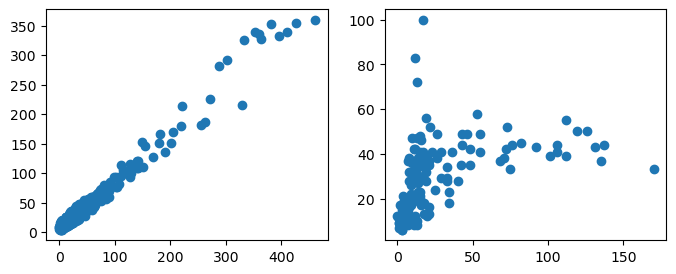

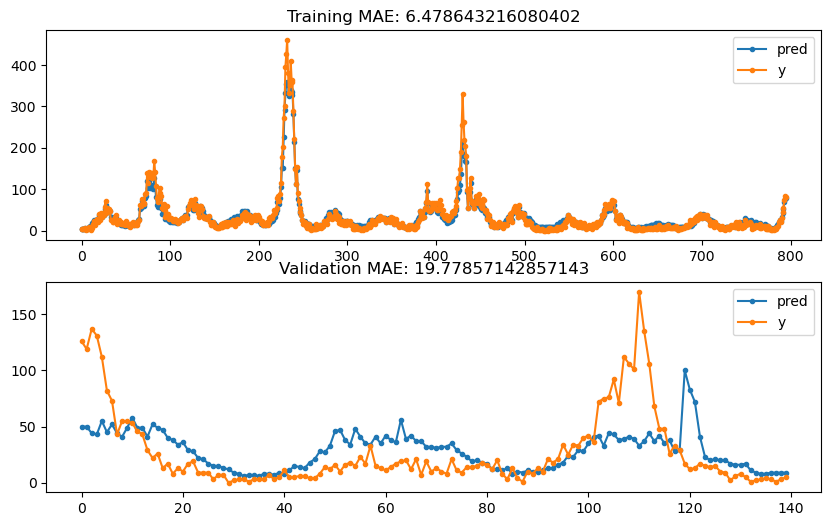

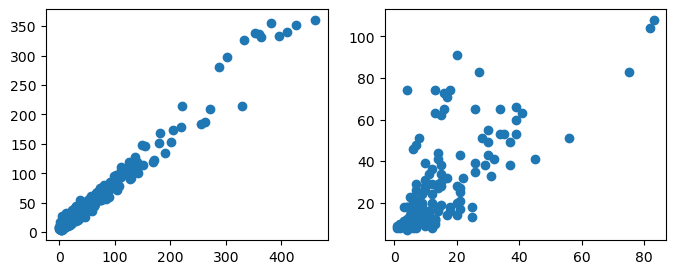

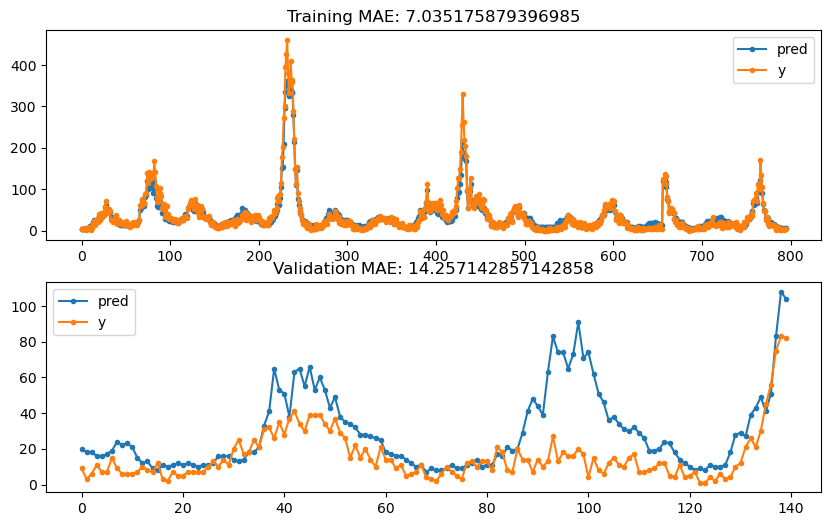

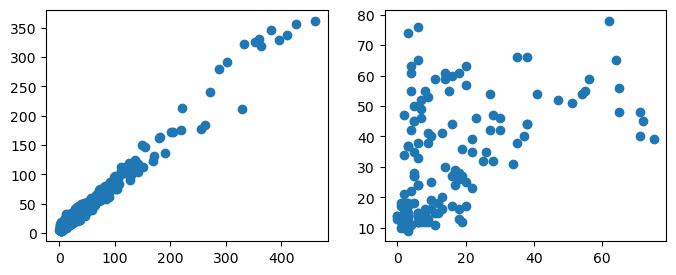

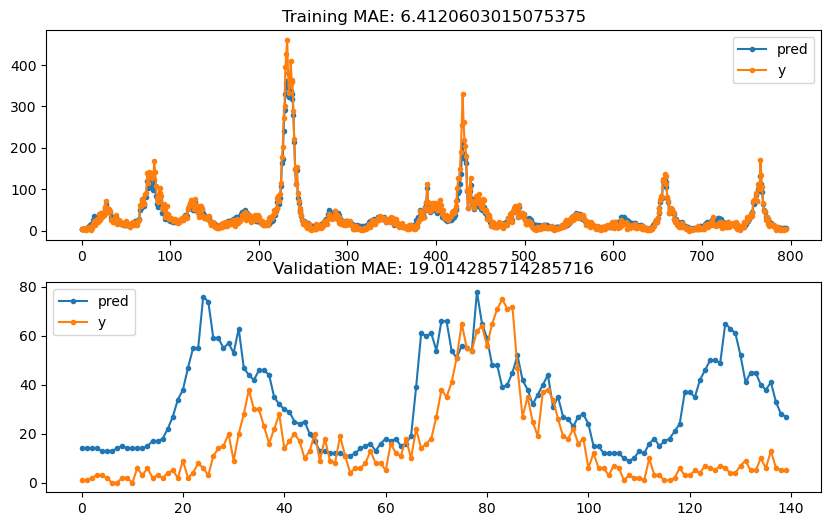

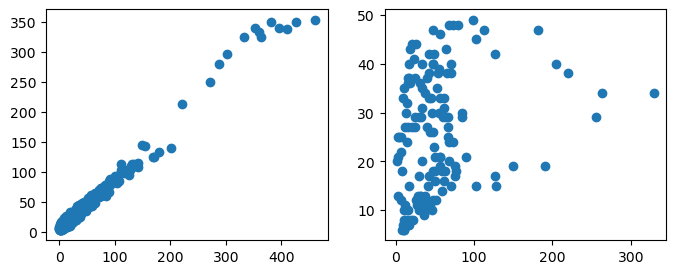

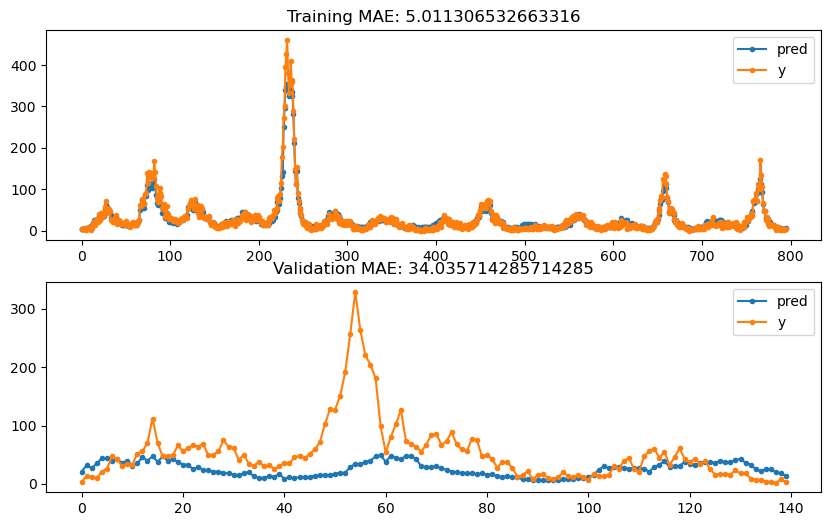

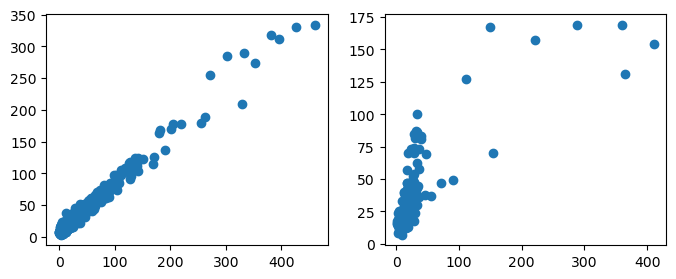

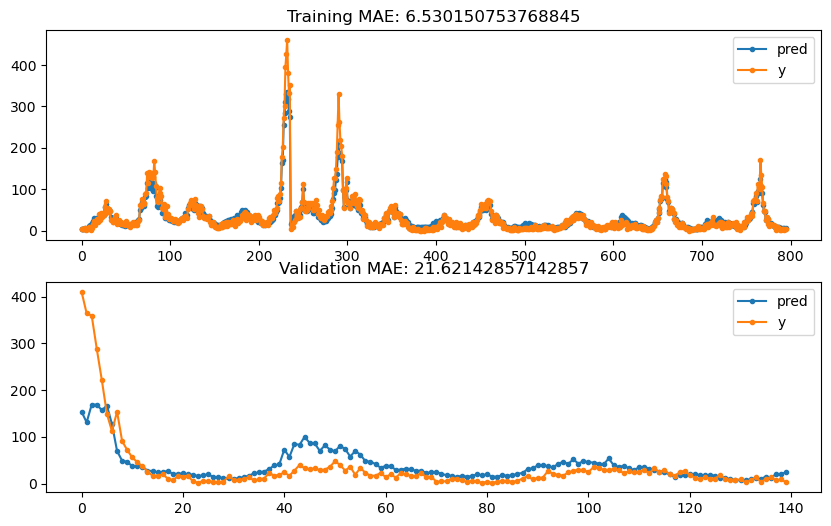

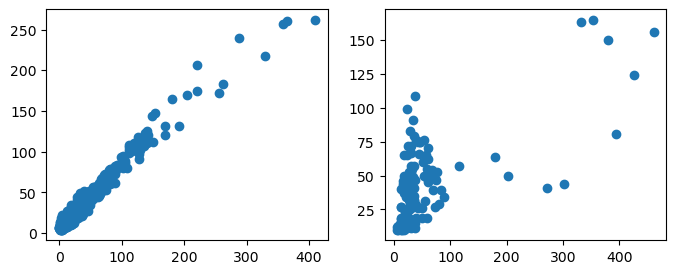

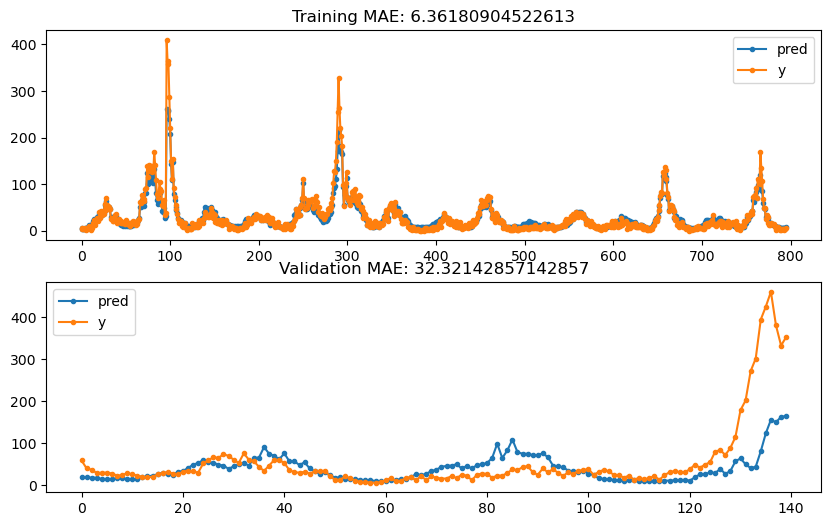

In [5]:
label_lags=(2,4,6,8,10)
feature_lags=(1,2,3,4,5,6,7,8,9,10)
folds = 6
fold_size = 0.15
xg_reg_sj = []

X_train_sj, X_val_sj, y_train_sj, y_val_sj,\
X_train_iq, X_val_iq, y_train_iq, y_val_iq = prep_data(label_lags=label_lags, feature_lags=feature_lags, folds=folds, fold_size=fold_size)

# Reducing all lagged label weights to reduce their selection
feature_weights = 100*np.ones(X_train_sj[0].shape[1])
feature_weights[-len(label_lags):] = 1

for fold in range(folds):
    print(f'\n ~~~~~~~~~~~~~~ Running fold {fold+1} of {folds} ~~~~~~~~~~~~~~ ')
    # print(f'Training on size {len(X_train_sj[fold])}, validating on size {len(X_val_sj[fold])}')
    xg_reg_sj.append(create_XGBmodel(eta=0.01,n_estimators=500,max_depth=5,objective='reg:squarederror',reg_alpha=10,reg_lambda=10))
    modelfit(xg_reg_sj[fold], X_train_sj[fold], y_train_sj[fold],
            useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
            trainCV_metrics = 'mae', eval_metric = 'mae',
            report_metric = metrics.mean_absolute_error, verbose=False,
            feature_weights=feature_weights)
    pred_train_sj, pred_val_sj,train_mae_sj, val_mae_sj = eval_and_plot(xg_reg_sj[fold],X_train_sj[fold],y_train_sj[fold],
                                            X_val_sj[fold],y_val_sj[fold],is_label_lagged=True,
                                            label_lags=label_lags,verbose=False,plot=True, MC=None)


 ~~~~~~~~~~~~~~ Running fold 1 of 6 ~~~~~~~~~~~~~~ 

 ~~~~~~~~~~~~~~ Running fold 2 of 6 ~~~~~~~~~~~~~~ 

 ~~~~~~~~~~~~~~ Running fold 3 of 6 ~~~~~~~~~~~~~~ 

 ~~~~~~~~~~~~~~ Running fold 4 of 6 ~~~~~~~~~~~~~~ 

 ~~~~~~~~~~~~~~ Running fold 5 of 6 ~~~~~~~~~~~~~~ 

 ~~~~~~~~~~~~~~ Running fold 6 of 6 ~~~~~~~~~~~~~~ 


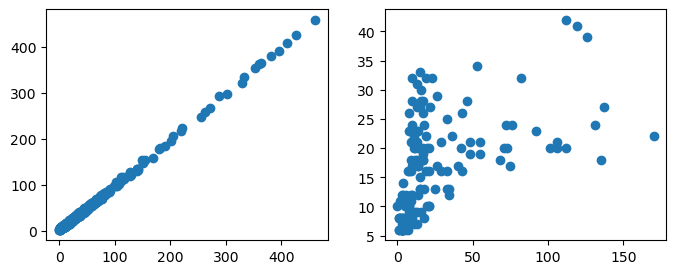

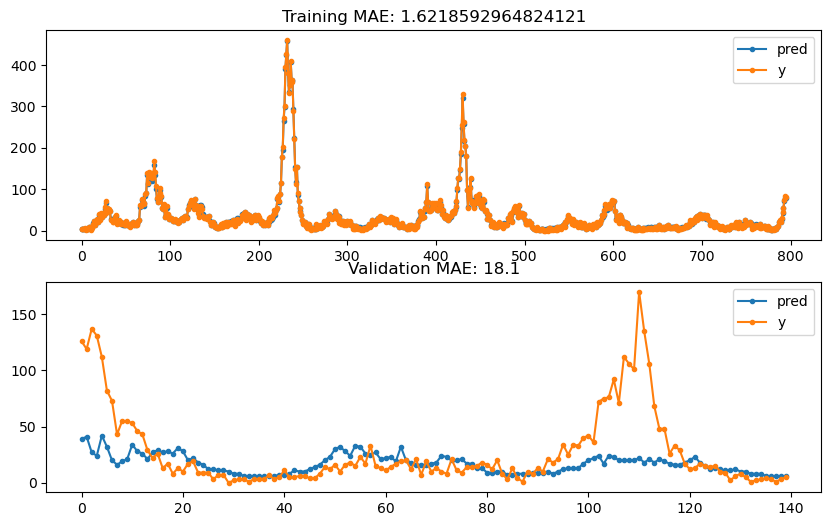

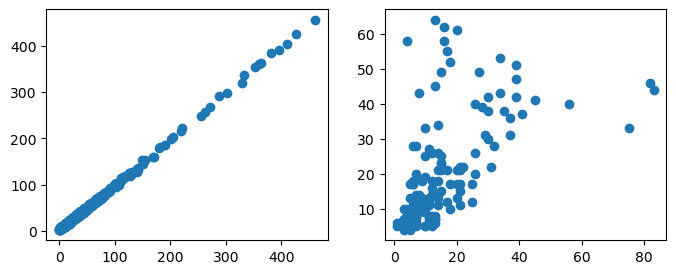

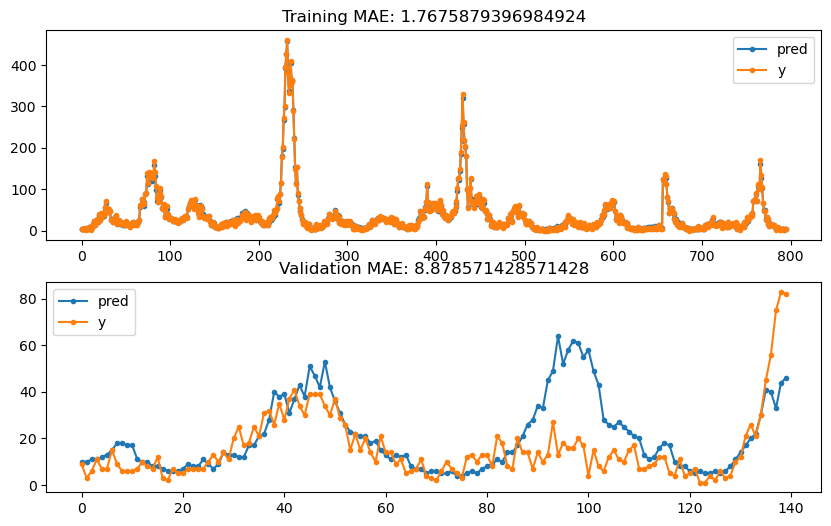

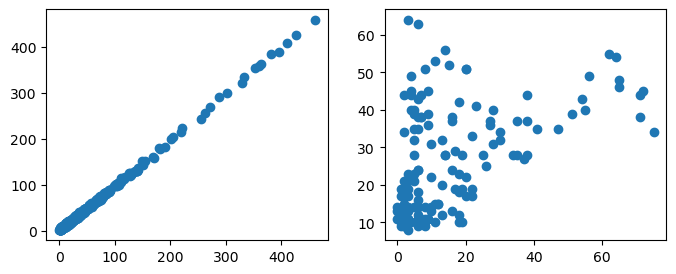

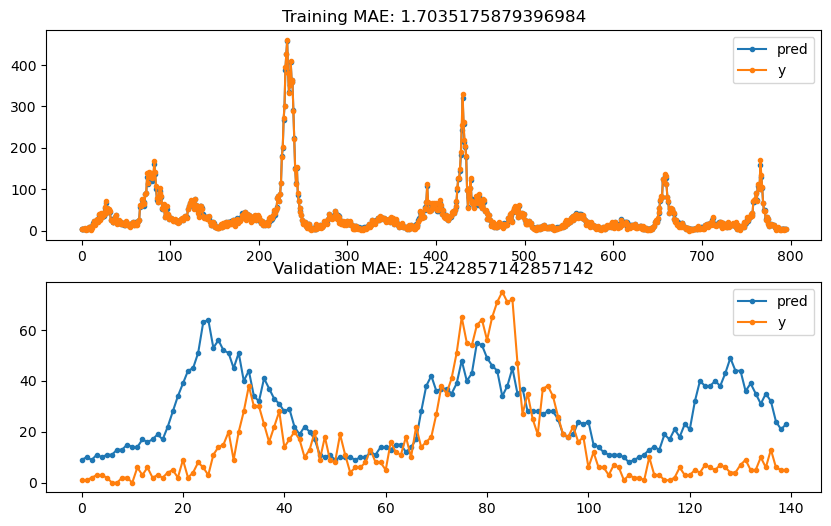

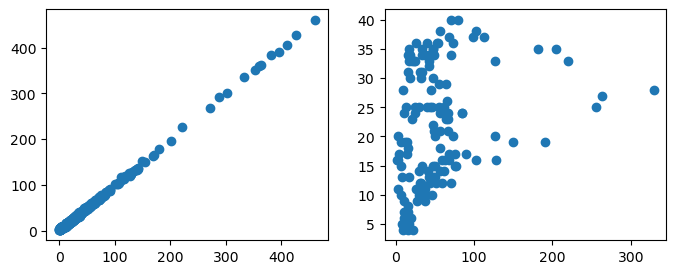

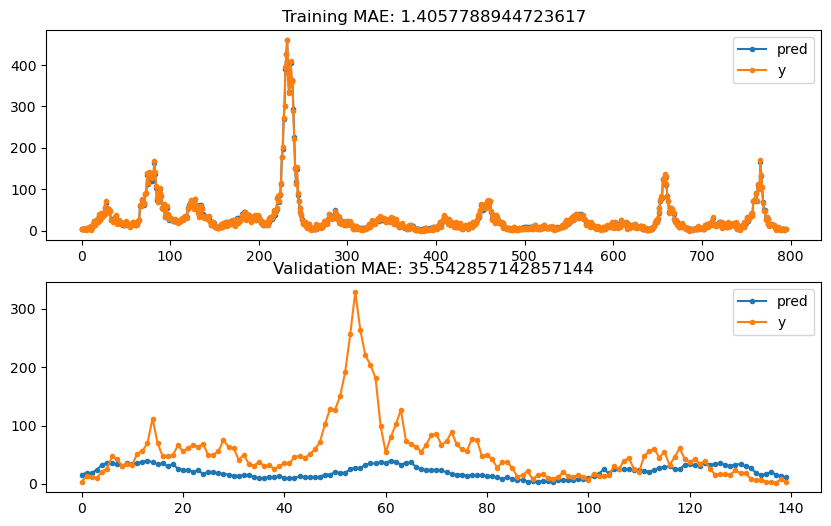

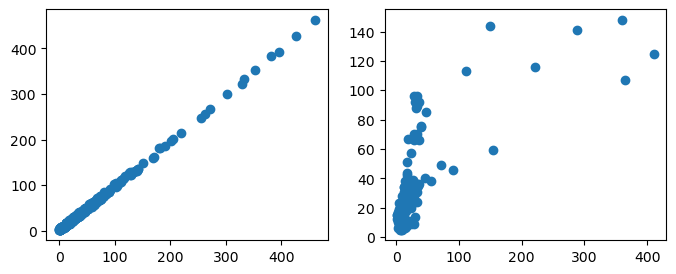

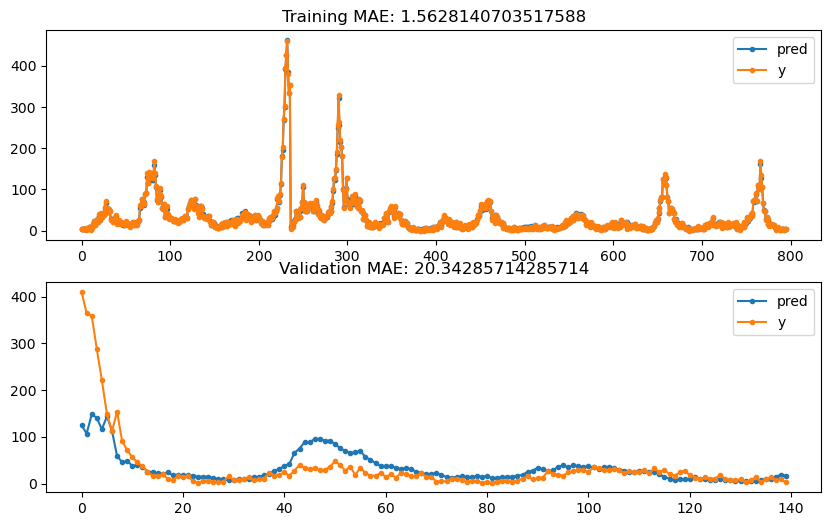

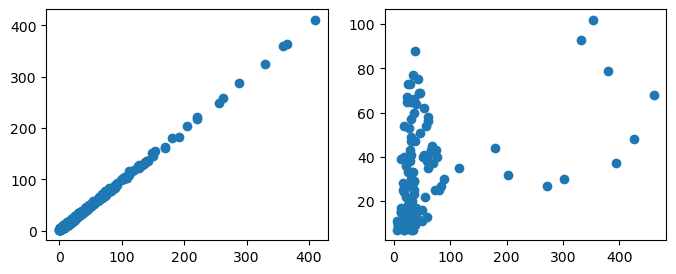

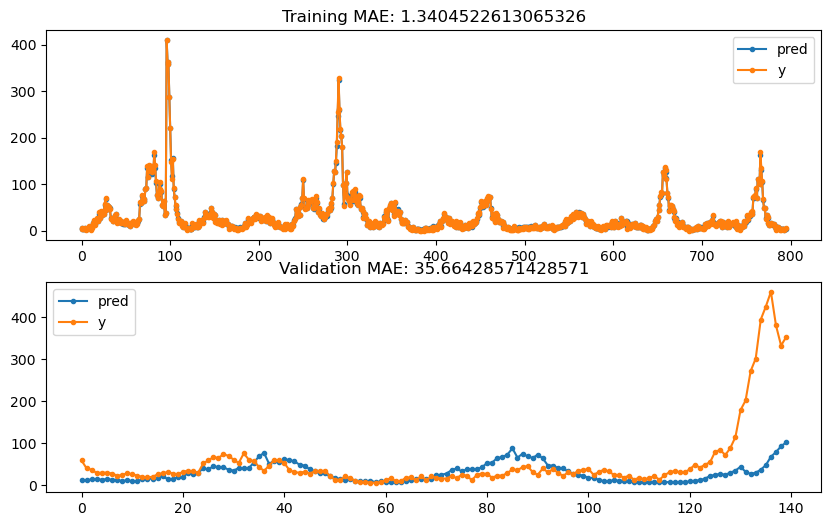

In [7]:
label_lags=(1,2,3,4,5,6,7,8,10)
feature_lags=(1,2,3,4,5,6,7,8,9,10)
folds = 6
fold_size = 0.15
xg_reg_sj = []

X_train_sj, X_val_sj, y_train_sj, y_val_sj,\
X_train_iq, X_val_iq, y_train_iq, y_val_iq = prep_data(label_lags=label_lags, feature_lags=feature_lags, folds=folds, fold_size=fold_size)

# Reducing all lagged label weights to reduce their selection
feature_weights = 100*np.ones(X_train_sj[0].shape[1])
feature_weights[-len(label_lags):] = 1

for fold in range(folds):
    print(f'\n ~~~~~~~~~~~~~~ Running fold {fold+1} of {folds} ~~~~~~~~~~~~~~ ')
    # print(f'Training on size {len(X_train_sj[fold])}, validating on size {len(X_val_sj[fold])}')
    xg_reg_sj.append(create_XGBmodel(eta=0.01,n_estimators=5000,max_depth=5,objective='count:poisson',reg_alpha=10,reg_lambda=10))
    modelfit(xg_reg_sj[fold], X_train_sj[fold], y_train_sj[fold],
            useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
            trainCV_metrics = 'mae', eval_metric = 'mae',
            report_metric = metrics.mean_absolute_error, verbose=False,
            feature_weights=feature_weights)
    pred_train_sj, pred_val_sj,train_mae_sj, val_mae_sj = eval_and_plot(xg_reg_sj[fold],X_train_sj[fold],y_train_sj[fold],
                                            X_val_sj[fold],y_val_sj[fold],is_label_lagged=True,
                                            label_lags=label_lags,verbose=False,plot=True, MC=None)

#### Iquitos (IQ)


 ~~~~~~~~~~~~~~ Running fold 0 of 6 ~~~~~~~~~~~~~~ 

 ~~~~~~~~~~~~~~ Running fold 1 of 6 ~~~~~~~~~~~~~~ 

 ~~~~~~~~~~~~~~ Running fold 2 of 6 ~~~~~~~~~~~~~~ 

 ~~~~~~~~~~~~~~ Running fold 3 of 6 ~~~~~~~~~~~~~~ 

 ~~~~~~~~~~~~~~ Running fold 4 of 6 ~~~~~~~~~~~~~~ 

 ~~~~~~~~~~~~~~ Running fold 5 of 6 ~~~~~~~~~~~~~~ 


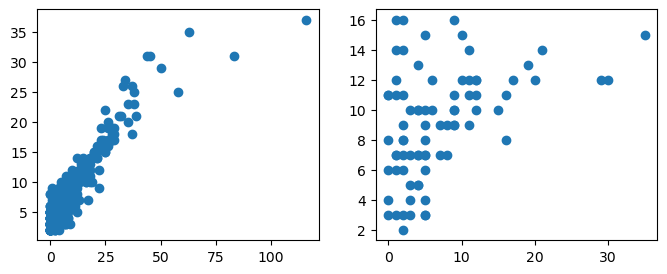

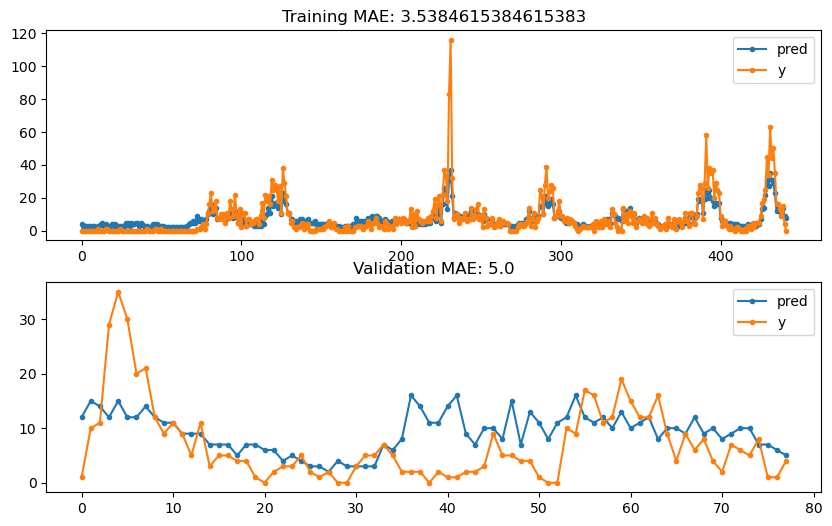

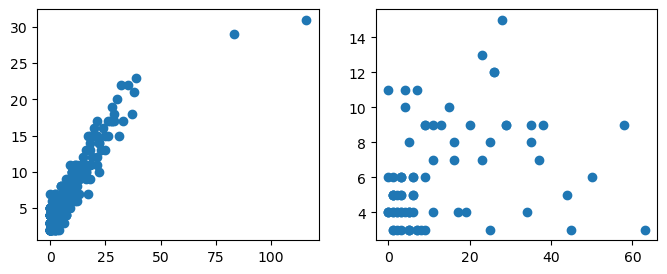

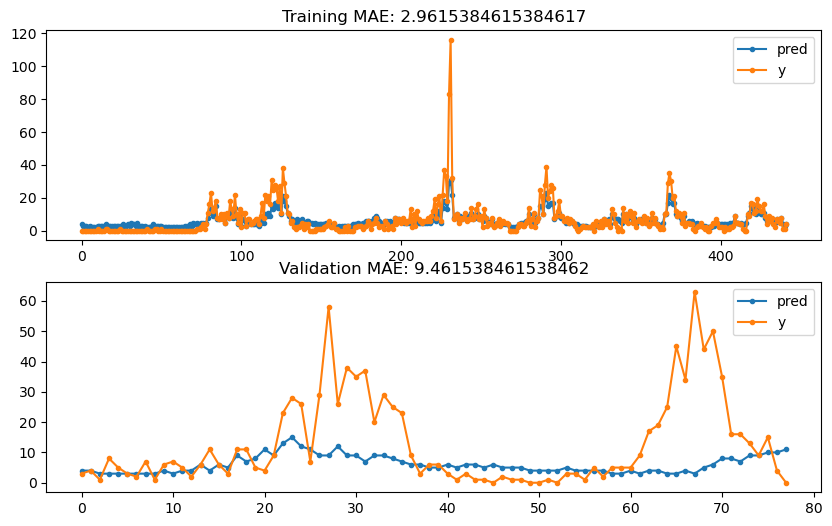

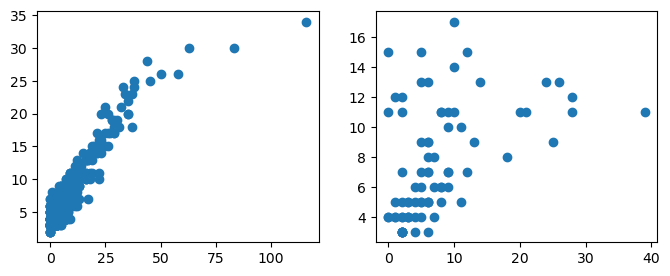

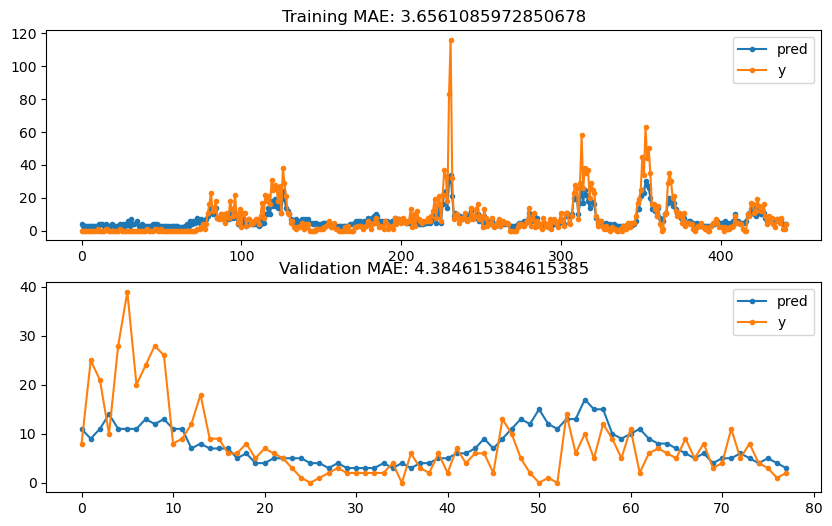

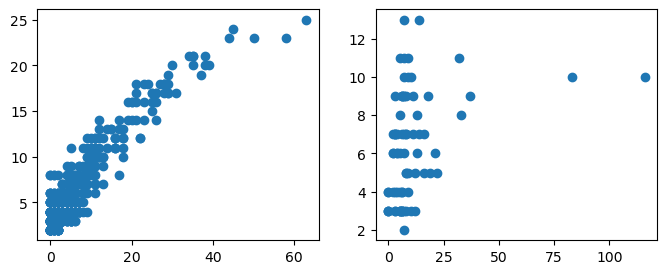

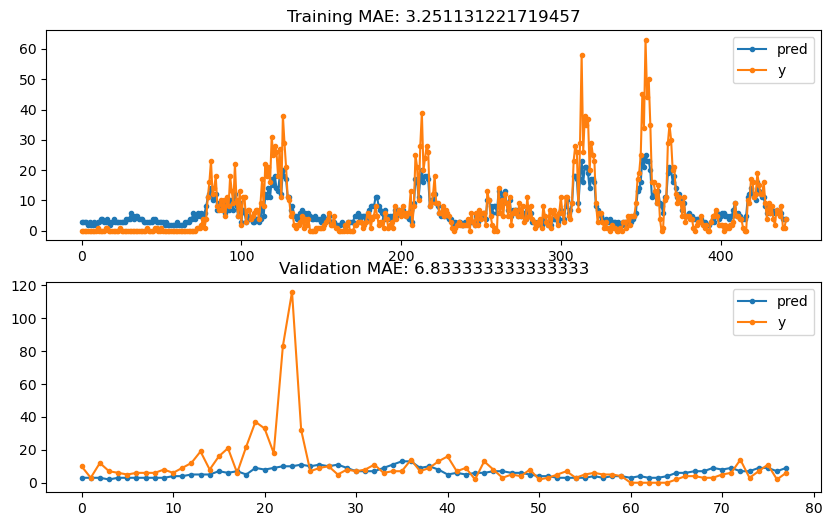

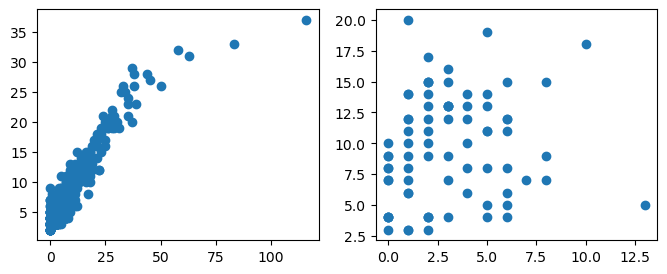

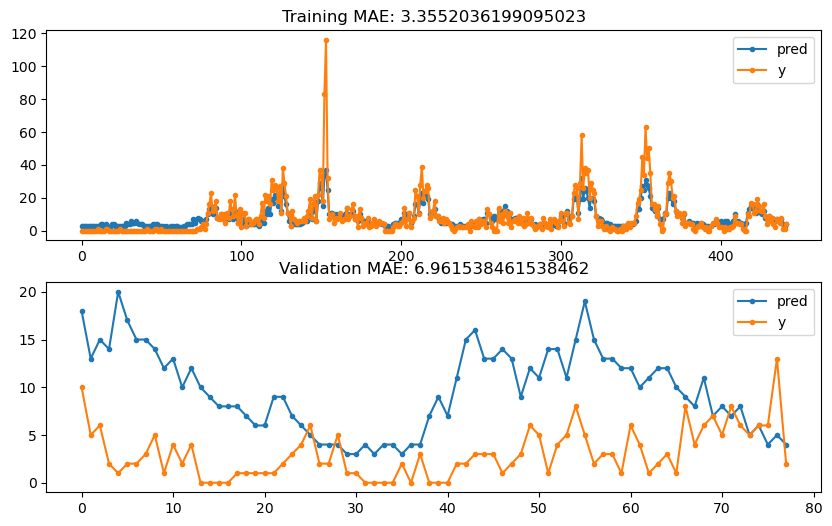

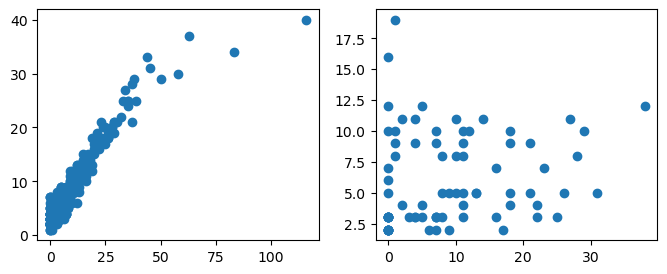

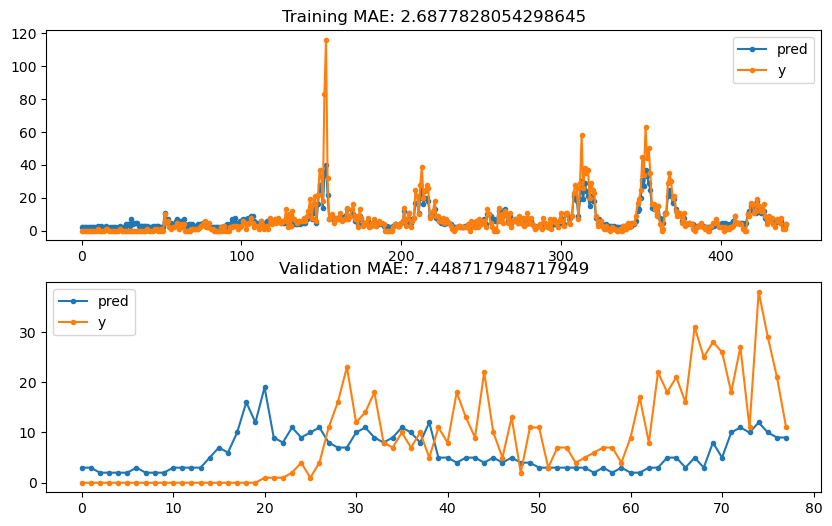

In [61]:
label_lags=(1,)
feature_lags=(1,2,3,4,5)
folds = 6
fold_size = 0.15
xg_reg_iq = []

X_train_sj, X_val_sj, y_train_sj, y_val_sj,\
X_train_iq, X_val_iq, y_train_iq, y_val_iq = prep_data(label_lags=label_lags, feature_lags=feature_lags, folds=folds, fold_size=fold_size)

# Reducing all lagged label weights to reduce their selection
feature_weights = 100*np.ones(X_train_iq[0].shape[1])
feature_weights[-len(label_lags):] =0.01

for fold in range(folds):
    
    
    print(f'\n ~~~~~~~~~~~~~~ Running fold {fold} of {folds} ~~~~~~~~~~~~~~ ')
    # print(f'Training on size {len(X_train_sj[fold])}, validating on size {len(X_val_sj[fold])}')
    xg_reg_iq.append(create_XGBmodel(eta=0.01,n_estimators=500,max_depth=5,objective='reg:squarederror',reg_alpha=10,reg_lambda=10))
    modelfit(xg_reg_iq[fold], X_train_iq[fold], y_train_iq[fold],
            useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
            trainCV_metrics = 'mae', eval_metric = 'mae',
            report_metric = metrics.mean_absolute_error, verbose=False,
            feature_weights=feature_weights)
    pred_train_iq, pred_val_iq,train_mae_iq, val_mae_iq = eval_and_plot(xg_reg_iq[fold],X_train_iq[fold],y_train_iq[fold],
                                            X_val_iq[fold],y_val_iq[fold],is_label_lagged=True,
                                            label_lags=label_lags,verbose=False,plot=True, MC=None)

## Predict and Submit


Model Report
<function mean_absolute_error at 0x000001DF08280720>
4.27064919930238

Model Report
<function mean_absolute_error at 0x000001DF08280720>
1.3522193597199825


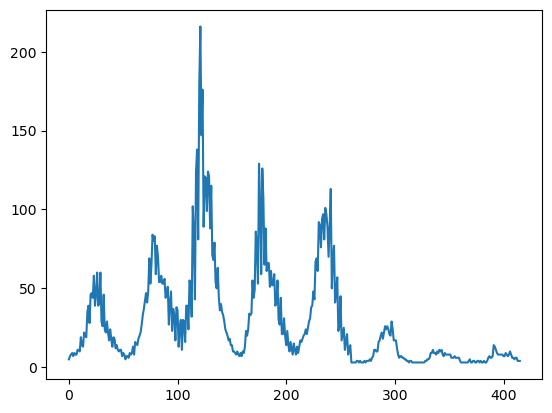

In [9]:
# sj training data
label_lags=(3,4,)
feature_lags=(3,)

lagged_features = temp_feature_names
train_features = preprocess(train_features_or,temp_feature_names,
                            lagged_features,feature_lags,is_label_lagged=True,label_lags=label_lags,labels=train_labels)

feature_weights = 100*np.ones(train_features.shape[1])
feature_weights[-len(label_lags):] =1

sj_mask = train_features['city_sj']
iq_mask = ~sj_mask
sj_train_features = train_features.copy().loc[sj_mask,[col for col in train_features.columns if col != 'city_sj']]
sj_train_labels = train_labels[sj_mask]

# sj load augmented (with lagged labels) test features
lagged_label_names = ['total_cases_'+str(i) for i in label_lags]
test_features_aug_or = pd.read_csv('./data/dengue_features_test2.csv',
                             index_col=[1,2])
test_features_aug = preprocess(test_features_aug_or,
                               temp_feature_names+lagged_label_names,
                               lagged_features,feature_lags,is_label_lagged=False)
sj_mask = test_features_aug['city_sj']
iq_mask = ~sj_mask
sj_test_features_aug = test_features_aug.copy().loc[sj_mask,[col for col in test_features_aug.columns if col != 'city_sj']]
order_needed = sj_train_features.columns.to_list()
sj_test_features_aug = sj_test_features_aug[order_needed]


# sj. Predict and submit
xg_reg_sj = create_XGBmodel(eta=0.01,n_estimators=500,max_depth=5,objective='reg:squarederror',reg_alpha=1,reg_lambda=1)
modelfit(xg_reg_sj, sj_train_features, sj_train_labels, useTrainCV=True, cv_folds=5, early_stopping_rounds=50,trainCV_metrics = 'mae', eval_metric = 'mae',report_metric = metrics.mean_absolute_error,feature_weights=feature_weights)
sj_pred_val = get_predictions(xg_reg_sj,sj_test_features_aug,label_lags,is_label_lagged=True,MC=None)

# iq training data
label_lags=(1,)
feature_lags=(1,2,3,4,5)


lagged_features = temp_feature_names
train_features = preprocess(train_features_or,temp_feature_names,
                            lagged_features,feature_lags,is_label_lagged=True,label_lags=label_lags,labels=train_labels)

feature_weights = 100*np.ones(train_features.shape[1])
feature_weights[-len(label_lags):] =0.01

sj_mask = train_features['city_sj']
iq_mask = ~sj_mask

iq_train_features = train_features.copy().loc[iq_mask,[col for col in train_features.columns if col != 'city_sj']]
iq_train_labels = train_labels[iq_mask]

# iq load augmented (with lagged labels) test features
lagged_label_names = ['total_cases_'+str(i) for i in label_lags]
test_features_aug_or = pd.read_csv('./data/dengue_features_test2.csv',
                             index_col=[1,2])
test_features_aug = preprocess(test_features_aug_or,
                               temp_feature_names+lagged_label_names,
                               lagged_features,feature_lags,is_label_lagged=False)
sj_mask = test_features_aug['city_sj']
iq_mask = ~sj_mask
iq_test_features_aug = test_features_aug.copy().loc[iq_mask,[col for col in test_features_aug.columns if col != 'city_sj']]
order_needed = iq_train_features.columns.to_list()
iq_test_features_aug = iq_test_features_aug[order_needed]

# iq. Predict and submit
xg_reg_iq = create_XGBmodel(eta=0.01,n_estimators=500,max_depth=5,objective='reg:squarederror',reg_alpha=1,reg_lambda=1)
modelfit(xg_reg_iq, iq_train_features, iq_train_labels, useTrainCV=True, cv_folds=5, early_stopping_rounds=50,trainCV_metrics = 'mae', eval_metric = 'mae',report_metric = metrics.mean_absolute_error,feature_weights=feature_weights)
iq_pred_val = get_predictions(xg_reg_iq,iq_test_features_aug,label_lags,is_label_lagged=True,MC=None)

pred_sj = np.round(sj_pred_val).astype('int')
pred_iq = np.round(iq_pred_val).astype('int')
pred_all = np.concatenate([pred_sj,pred_iq])
plt.plot(pred_all)

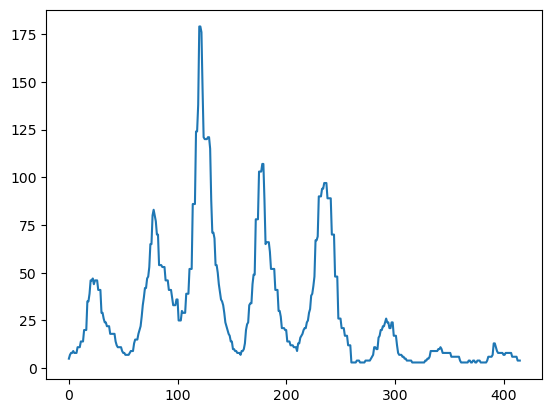

In [10]:
from scipy.signal import medfilt

pred_all_filt = medfilt(pred_all,3)
plt.plot(pred_all_filt)

In [11]:
# with medfilt
submission = pd.read_csv("./data/submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = pred_all_filt.astype(int)
submission.to_csv("./submission_17.csv")